Interactive AADC Spline Visualization (Static Version)

This notebook demonstrates visualization of cubic spline interpolation using AADC (Algorithmic Automatic Differentiation for C++).
Originally interactive, this version shows static plots of:

1. Different knot point configurations
2. Various function shapes
3. Different evaluation points
4. Sensitivities to parameters

In [1]:
# Setup and Imports
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import CubicSpline as ScipySpline

In [2]:
import aadc
from aadc.scipy.interpolate import CubicSpline

In [3]:
# Define the AADC spline functions
def create_spline_kernel(x_values, y_values, x0_value, bc_type="not-a-knot"):
    with aadc.record_kernel() as kernel:
        # Convert inputs to AADC arrays
        x_active = aadc.array(x_values)
        x_arg = x_active.mark_as_input()

        y_active = aadc.array(y_values)
        y_arg = y_active.mark_as_input()

        # Create spline
        spline = CubicSpline(x_active, y_active, bc_type=bc_type)

        # Evaluation point
        x0 = aadc.idouble(x0_value)
        x0_arg = x0.mark_as_input()

        # Evaluate spline
        f = spline(x0)
        f_arg = f.mark_as_output()

    return kernel, x_arg, y_arg, x0_arg, f_arg

In [4]:
def evaluate_spline(kernel, x_values, y_values, x0_value, x_arg, y_arg, x0_arg, f_arg):
    # Prepare inputs
    inputs = {}
    inputs[x0_arg] = x0_value

    for i, val in enumerate(x_values):
        inputs[x_arg[i]] = val

    for i, val in enumerate(y_values):
        inputs[y_arg[i]] = val

    # Evaluate kernel
    request = {f_arg: list(x_arg) + list(y_arg) + [x0_arg]}
    result = aadc.evaluate(kernel, request, inputs)

    # Extract results and convert to proper format
    value = result[0][f_arg]
    # Handle scalar or array differently
    if isinstance(value, np.ndarray) and value.size == 1:
        value = value.item()  # Extract the scalar value from a size-1 array

    d_dx0 = result[1][f_arg][x0_arg]
    if isinstance(d_dx0, np.ndarray) and d_dx0.size == 1:
        d_dx0 = d_dx0.item()

    # Extract derivatives as lists
    d_dx = []
    for x_i in x_arg:
        deriv = result[1][f_arg][x_i]
        if isinstance(deriv, np.ndarray) and deriv.size == 1:
            d_dx.append(deriv.item())
        else:
            d_dx.append(deriv)

    d_dy = []
    for y_i in y_arg:
        deriv = result[1][f_arg][y_i]
        if isinstance(deriv, np.ndarray) and deriv.size == 1:
            d_dy.append(deriv.item())
        else:
            d_dy.append(deriv)

    return value, d_dx0, d_dx, d_dy

In [5]:
# Function to create visualization
def create_spline_plot(x_values, y_values, x0_value, bc_type="not-a-knot", title=None):
    # Create kernel
    kernel, x_arg, y_arg, x0_arg, f_arg = create_spline_kernel(x_values, y_values, x0_value, bc_type)
    
    # Evaluate the spline at x0
    value, d_dx0, d_dx, d_dy = evaluate_spline(kernel, x_values, y_values, x0_value, x_arg, y_arg, x0_arg, f_arg)

    # Create a fine grid for plotting the spline
    x_fine = np.linspace(min(x_values) - 0.5, max(x_values) + 0.5, 200)

    # Use SciPy for visualization (faster than evaluating AADC at each point)
    scipy_spline = ScipySpline(x_values, y_values, bc_type=bc_type)
    y_fine = scipy_spline(x_fine)

    # Set up the figure with GridSpec for better layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, height_ratios=[2, 1])

    # Main plot - spline curve and points
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(x_fine, y_fine, 'b-', label='Cubic Spline')
    ax1.plot(x_values, y_values, 'ro', markersize=8, label='Knot Points')
    ax1.axvline(x=x0_value, color='g', linestyle='--', label='Evaluation Point')
    ax1.axhline(y=value, color='g', linestyle='--')
    ax1.plot(x0_value, value, 'g*', markersize=10, label=f'Spline(x0) = {value:.4f}')

    # Add derivative visualization as a tangent line
    tangent_width = 1.0
    x_tangent = np.array([x0_value - tangent_width/2, x0_value + tangent_width/2])
    y_tangent = value + d_dx0 * (x_tangent - x0_value)
    ax1.plot(x_tangent, y_tangent, 'g-', linewidth=2, label=f'Derivative at x0: {d_dx0:.4f}')

    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    if title:
        ax1.set_title(f'Cubic Spline Interpolation: {title}')
    else:
        ax1.set_title('Cubic Spline Interpolation')
    ax1.legend()
    ax1.grid(True)

    # Lower left - sensitivity to x
    ax2 = plt.subplot(gs[1, 0])
    ax2.bar(range(len(x_values)), d_dx, color='purple')
    ax2.set_xlabel('Knot Point Index')
    ax2.set_ylabel('Sensitivity ∂f/∂x')
    ax2.set_title('Sensitivity to X Values')
    ax2.set_xticks(range(len(x_values)))
    ax2.grid(True, axis='y')

    # Lower right - sensitivity to y
    ax3 = plt.subplot(gs[1, 1])
    ax3.bar(range(len(y_values)), d_dy, color='orange')
    ax3.set_xlabel('Knot Point Index')
    ax3.set_ylabel('Sensitivity ∂f/∂y')
    ax3.set_title('Sensitivity to Y Values')
    ax3.set_xticks(range(len(y_values)))
    ax3.grid(True, axis='y')

    plt.tight_layout()
    return fig

Create a series of static plots demonstrating different aspects

In [6]:
# 1. Basic example with sin(x)
num_points = 5
x_default = np.linspace(0, 10, num_points)
y_default = np.sin(x_default)
x0_default = 6.5

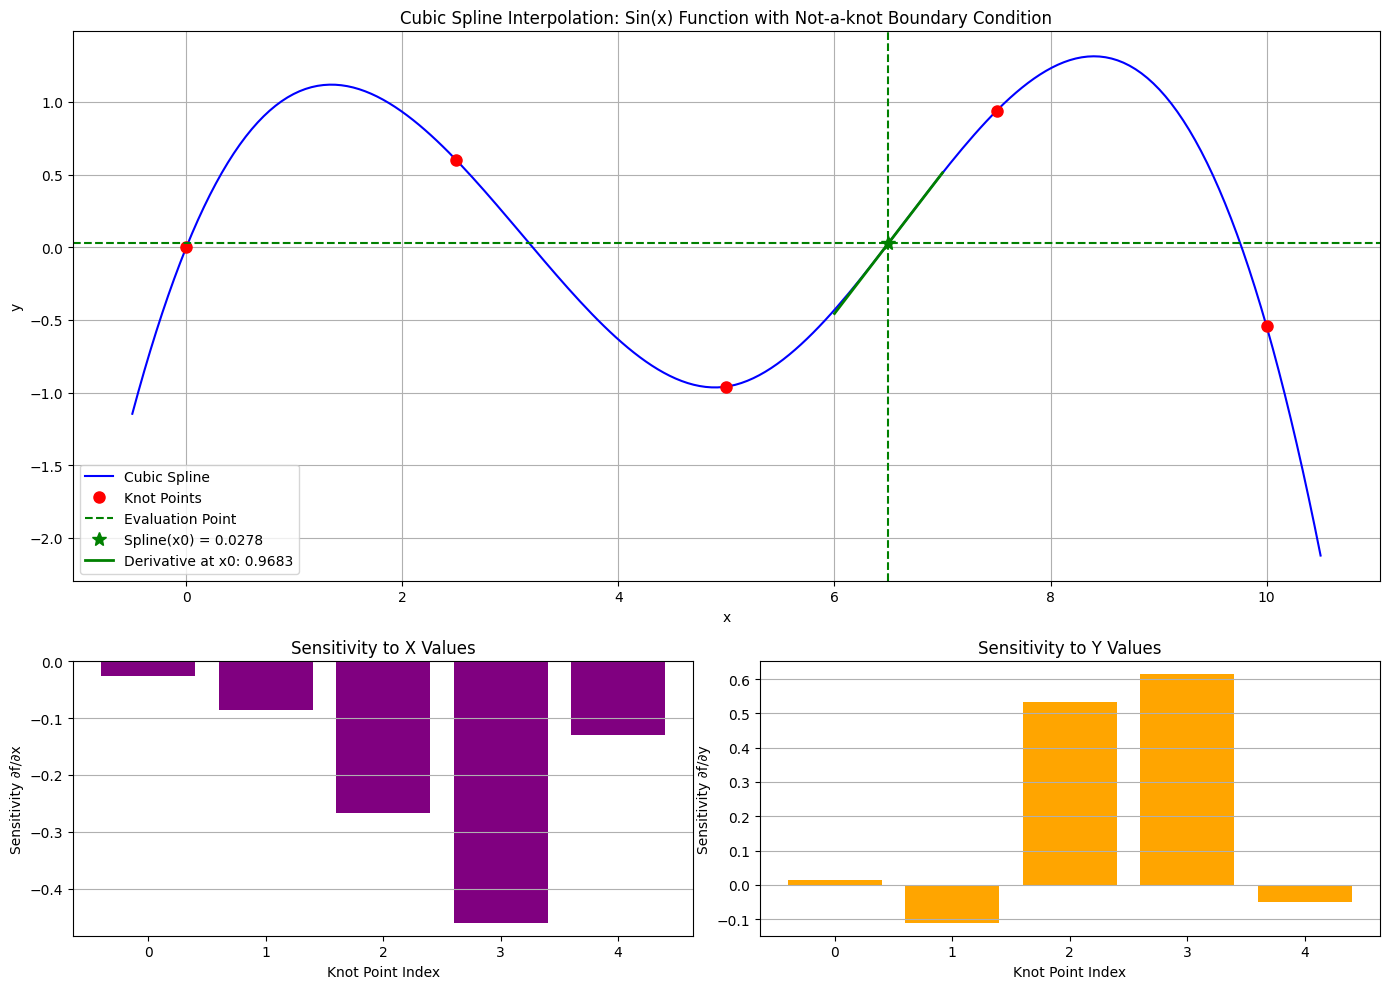

In [7]:
fig1 = create_spline_plot(x_default, y_default, x0_default, bc_type="not-a-knot", 
                          title="Sin(x) Function with Not-a-knot Boundary Condition")
plt.show()

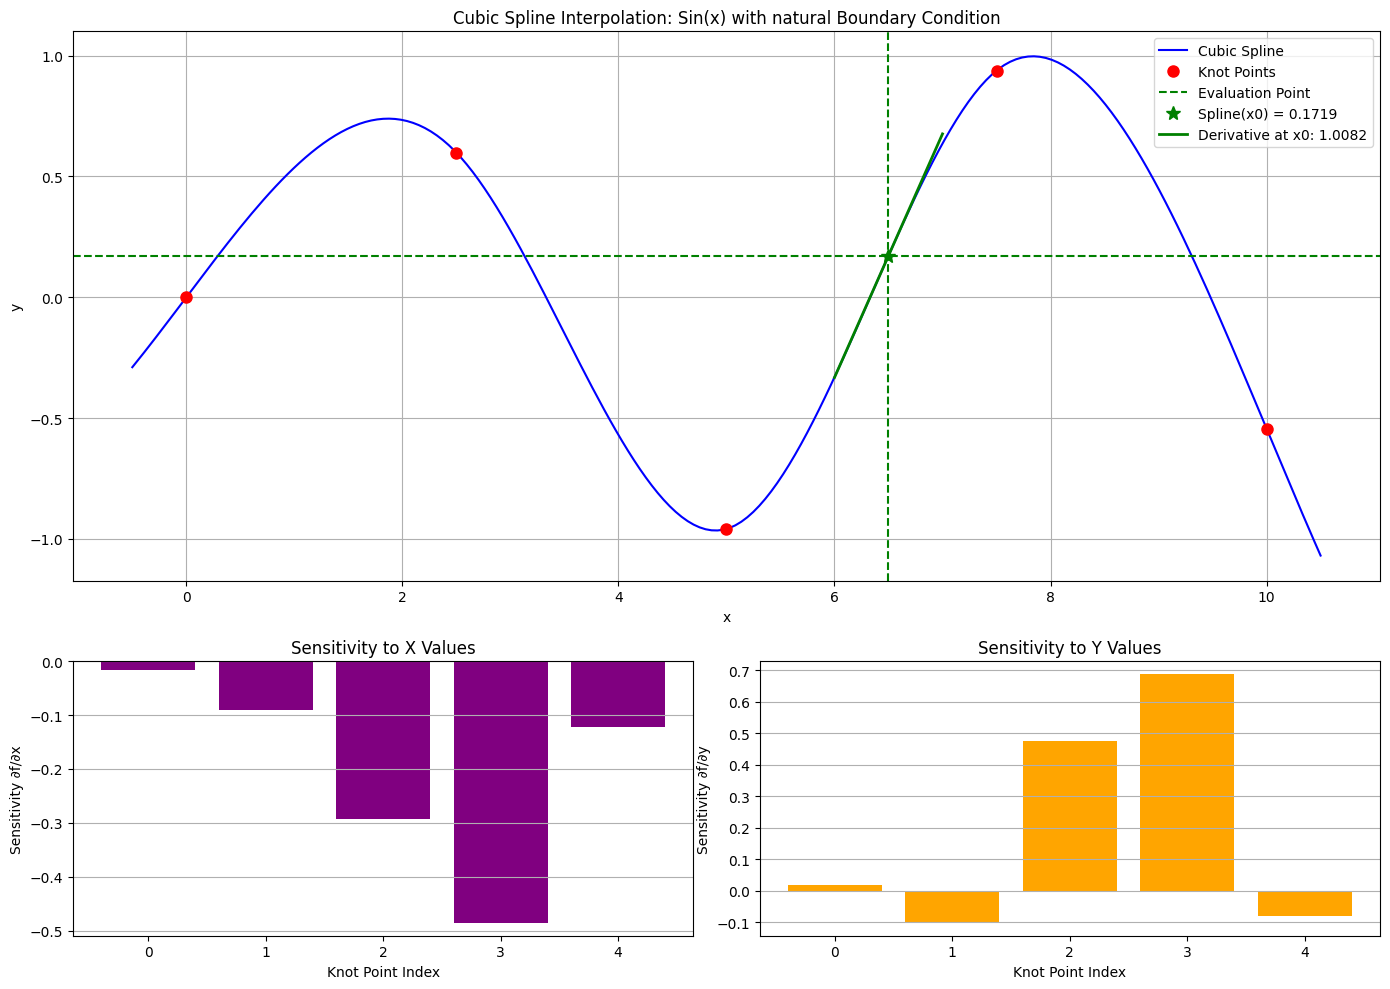

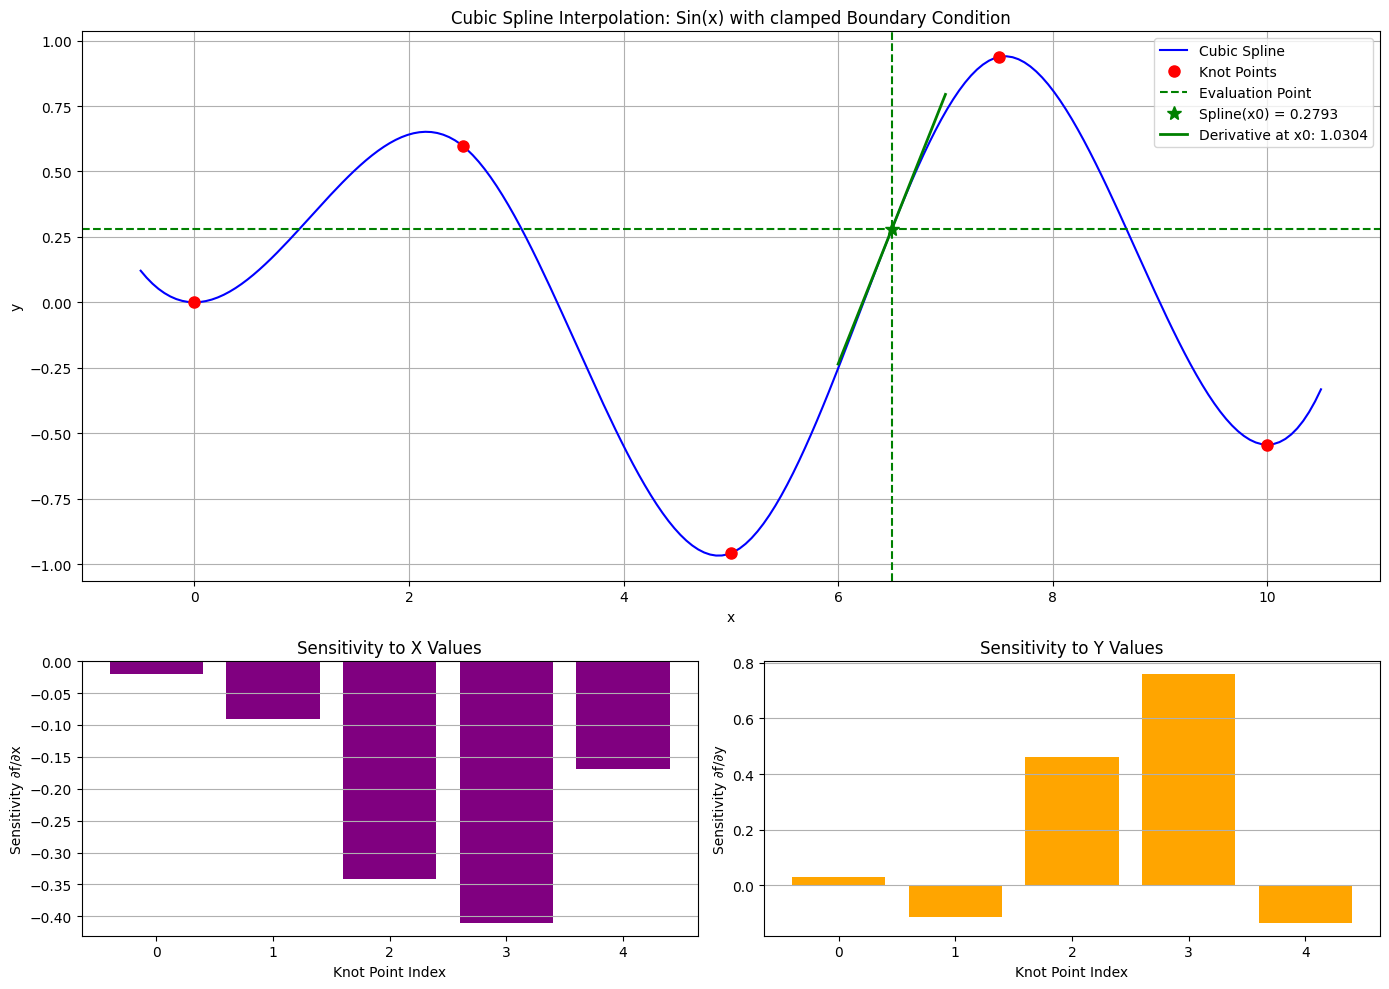

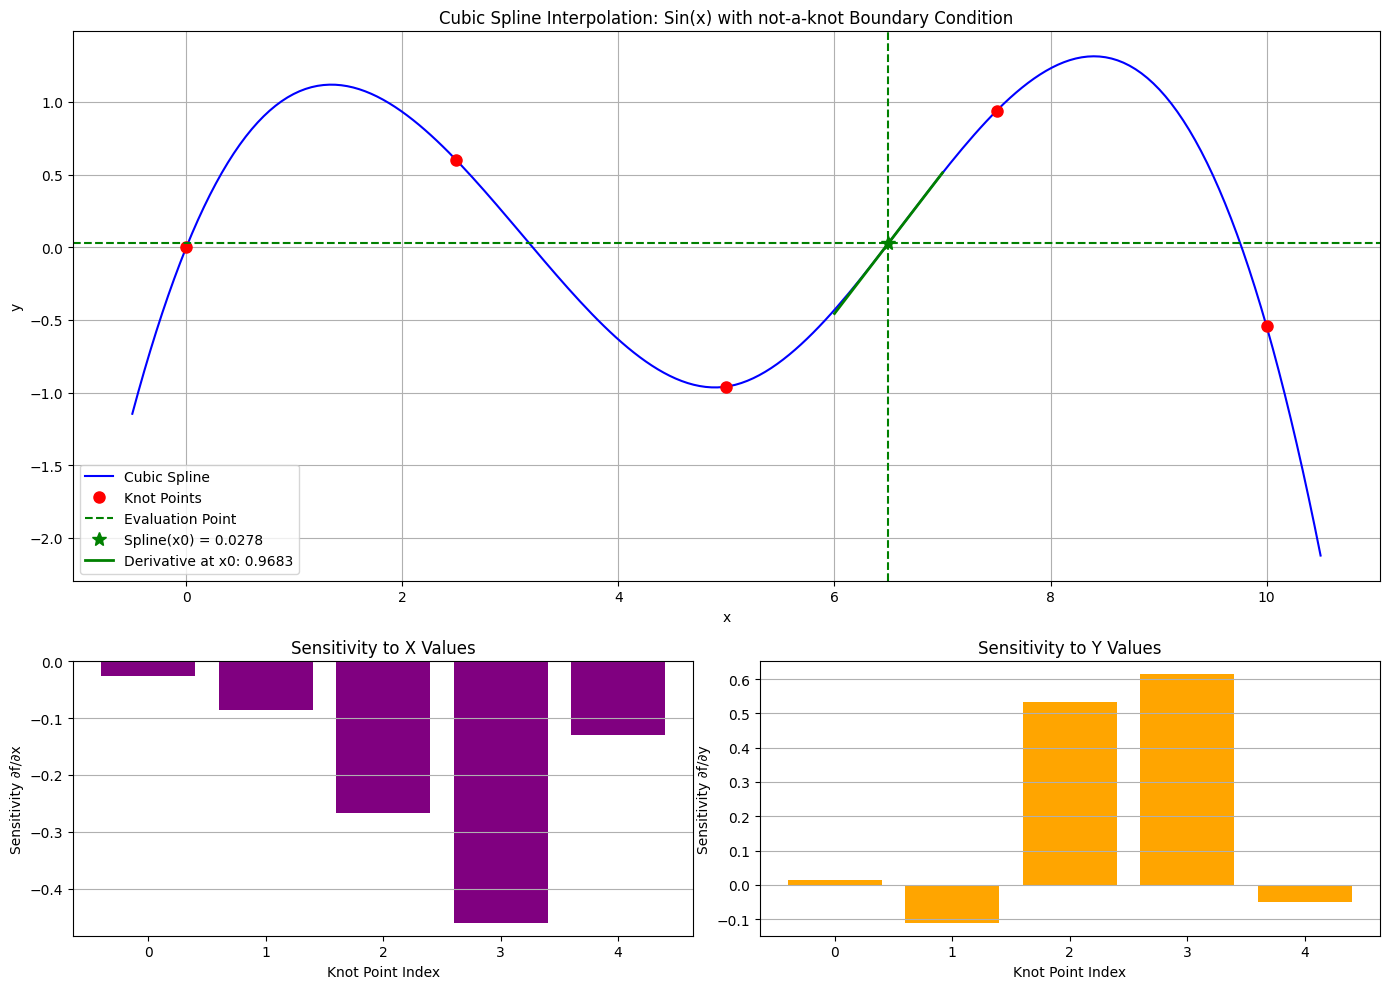

In [8]:
# 2. Different boundary conditions
bc_types = ["natural", "clamped", "not-a-knot"]
for bc_type in bc_types:
    fig = create_spline_plot(x_default, y_default, x0_default, bc_type=bc_type,
                             title=f"Sin(x) with {bc_type} Boundary Condition")
    plt.show()

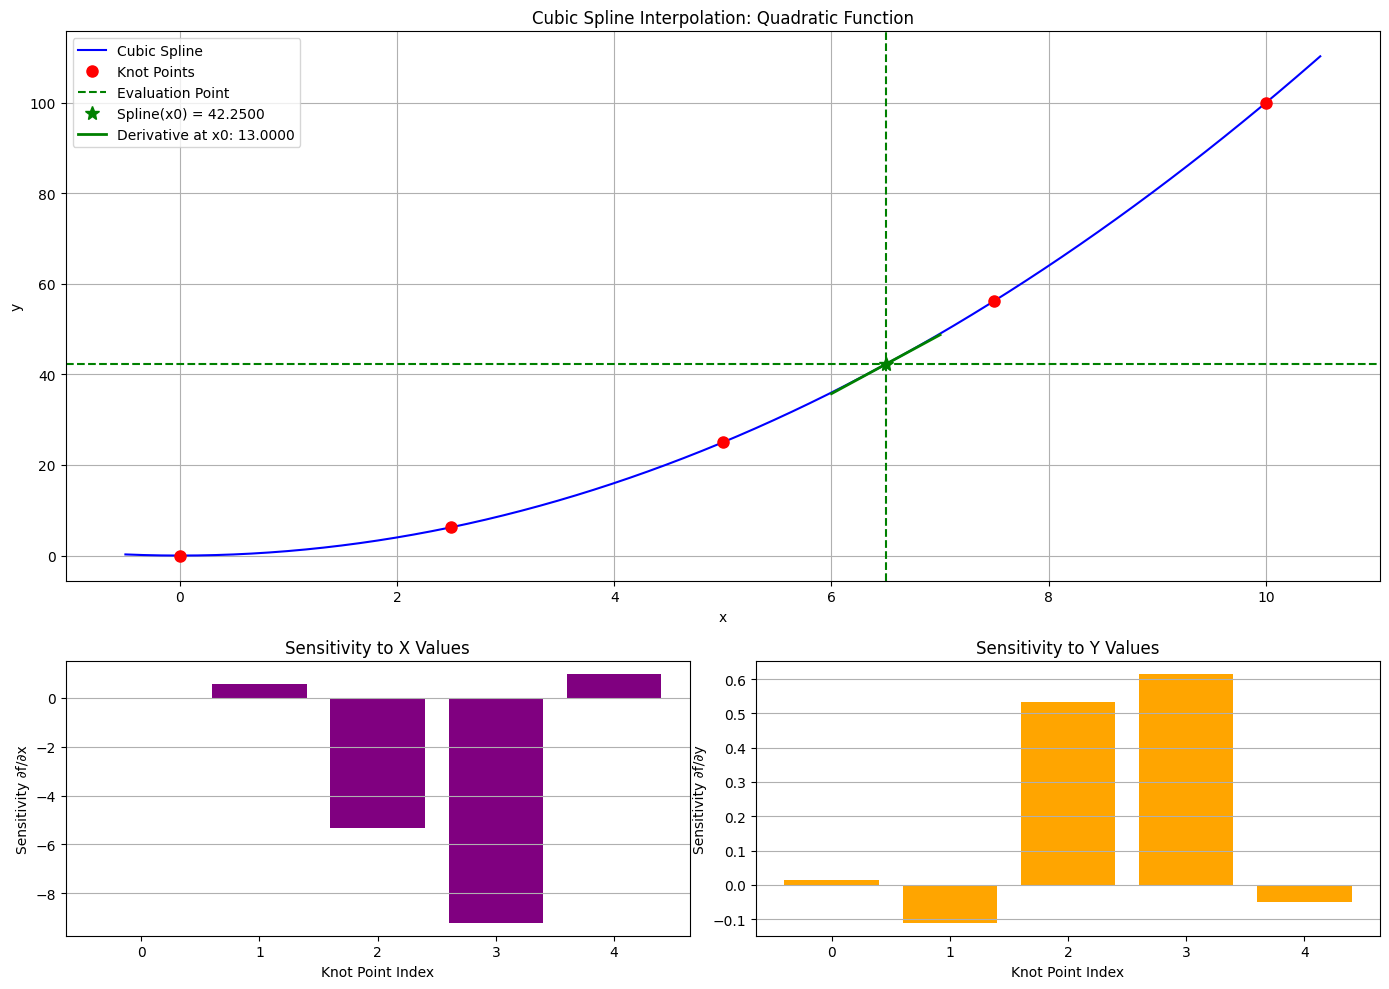

In [9]:
# 3. Different function types
# Quadratic
y_quadratic = x_default**2
fig3 = create_spline_plot(x_default, y_quadratic, x0_default, title="Quadratic Function")
plt.show()

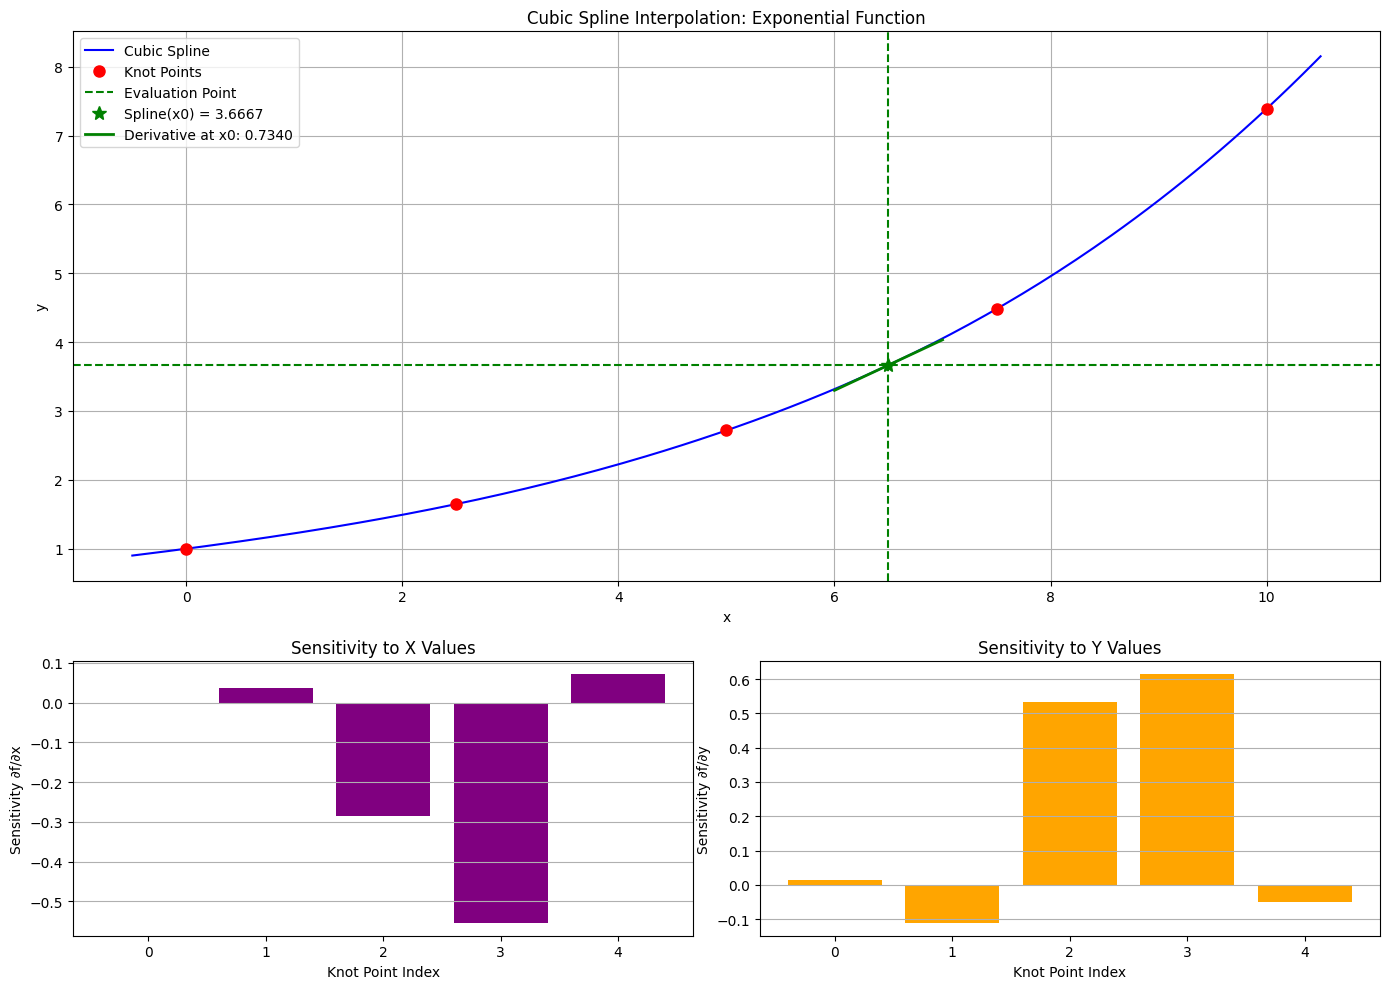

In [10]:
# Exponential
y_exponential = np.exp(x_default/5)
fig4 = create_spline_plot(x_default, y_exponential, x0_default, title="Exponential Function")
plt.show()